In [52]:
#Authors: Adam Lewandowski, Ivan Sladkov, Patrick English
import numpy as np
import pandas as pd
import time
from sklearn import svm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#Import Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#Import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
#Import vectorised tweets
vec_tweets = pd.read_csv("../vec.csv")

In [3]:
#Take target data from raw 
raw_tweets_df = pd.read_csv("data/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", header=None)
raw_tweets_df.columns = ['target', 'id','date','flag','user','text']
target_data = pd.DataFrame(raw_tweets_df["target"])

In [4]:
# Data join + train/test

combined_data = vec_tweets.join(target_data)


#train/test create
msk = np.random.rand(len(combined_data)) < 0.8
train = combined_data[msk]
test = combined_data[~msk]


# CHANGE FRAC TO INCREASE ROWS USED

In [5]:
#Sample dataframe for multiple model testing

sampled_df = combined_data.sample(frac=0.00625)

In [6]:
sampled_df.target.value_counts() # Visual check to ensure balance

0    5065
4    4935
Name: target, dtype: int64

In [36]:
#Data division

#Map pos/neg to 0/1
sampled_df["target"].replace(4, 1, inplace=True)

msk = np.random.rand(len(sampled_df)) < 0.8
train = sampled_df[msk]
test = sampled_df[~msk]



# Create X and Y for training

y_train = train.pop("target")
X_train = train

# Create X and Y for testing
y_test = test.pop("target")
X_test = test

In [53]:
#Model set-up
#Linear Regression
log_reg = LogisticRegression(solver="lbfgs",max_iter =10000)
log_reg.fit(X_train, y_train)

#kNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

#Random Forest
rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(X_train, y_train)

#Naieve Bayes - Multinomial
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

#SVM
lin_svm = svm.SVC(kernel="rbf",probability=True)
lin_svm.fit(X_train,y_train)


E:\Anaconda\envs\dl\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
E:\Anaconda\envs\dl\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

# This needs to be tidied up a lot

E:\Anaconda\envs\dl\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
E:\Anaconda\envs\dl\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\envs\dl\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,MultinomialNB,SVC
Accuracy,0.694500,0.600500,0.614000,0.683500,0.492
F1,0.702097,0.619705,0.697492,0.671851,0.000
Precision,0.695652,0.600000,0.579427,0.709748,0.000
Recall,0.708661,0.640748,0.875984,0.637795,0.000
Roc_auc,0.694270,0.599846,0.609740,0.684243,0.500


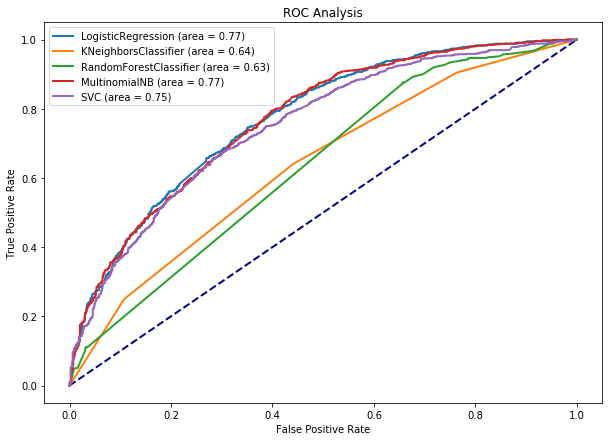

In [55]:
models = [log_reg,knn,rf,mnb,lin_svm ]


# ROC Curves Figure
orig_fig = plt.figure(figsize=(10,7))
plt.title('ROC Analysis')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
report_frame = {}
for model in models:
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    model_name = str(model.__class__).split('.')[-1].split('\'')[0]
    
    model_scores ={}
    model_scores['Accuracy'] = accuracy_score(y_test,y_pred)
    model_scores['F1'] = f1_score(y_test,y_pred)
    model_scores['Precision'] = precision_score(y_test,y_pred)
    model_scores["Recall"] = recall_score(y_test,y_pred)
    model_scores["Roc_auc"] = roc_auc_score(y_test,y_pred)
    report_frame[model_name] = model_scores
    #ROC
    fpr, tpr, t = roc_curve(y_test, y_score[:,1])
    roc_auc = auc(fpr, tpr)
    #plot roc
    plt.plot(fpr, tpr,
             lw=lw, label=str(model_name)+' (area = %0.2f)' % roc_auc)

        
plt.legend()
orig_frame = pd.DataFrame.from_dict(report_frame)
orig_frame